# Lesson 6: Essay Writer

In [3]:
%pip install -U langchain-community langgraph langchain-openai tavily-python load-dotenv

Note: you may need to restart the kernel to use updated packages.


In [4]:
from dotenv import load_dotenv

_ = load_dotenv()

In [5]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage

memory = SqliteSaver.from_conn_string(":memory:")

In [6]:
class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int

In [7]:
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-4o", temperature=0, openai_api_key = "sk-proj-zIHJSpOWDHXvTp18X3xmT3BlbkFJYA3qywn9JquqfOsNh03y")

In [8]:
PLAN_PROMPT = """You are an expert writer tasked with writing a high level outline of an essay. \
Write such an outline for the user provided topic. Give an outline of the essay along with any relevant notes \
or instructions for the sections."""

In [9]:
WRITER_PROMPT = """You are an essay assistant tasked with writing excellent 5-paragraph essays.\
Generate the best essay possible for the user's request and the initial outline. \
If the user provides critique, respond with a revised version of your previous attempts. \
Utilize all the information below as needed: 

------

{content}"""

In [10]:
REFLECTION_PROMPT = """You are a teacher grading an essay submission. \
Generate critique and recommendations for the user's submission. \
Provide detailed recommendations, including requests for length, depth, style, etc."""

In [11]:
RESEARCH_PLAN_PROMPT = """You are a researcher charged with providing information that can \
be used when writing the following essay. Generate a list of search queries that will gather \
any relevant information. Only generate 3 queries max."""


In [12]:
RESEARCH_CRITIQUE_PROMPT = """You are a researcher charged with providing information that can \
be used when making any requested revisions (as outlined below). \
Generate a list of search queries that will gather any relevant information. Only generate 3 queries max."""


In [13]:
from langchain_core.pydantic_v1 import BaseModel

class Queries(BaseModel):
    queries: List[str]

In [14]:
from tavily import TavilyClient
import os
tavily = TavilyClient(api_key="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")

In [15]:
def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=PLAN_PROMPT), 
        HumanMessage(content=state['task'])
    ]
    response = model.invoke(messages)
    return {"plan": response.content}

In [16]:
def research_plan_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [17]:
def generation_node(state: AgentState):
    content = "\n\n".join(state['content'] or [])
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")
    messages = [
        SystemMessage(
            content=WRITER_PROMPT.format(content=content)
        ),
        user_message
        ]
    response = model.invoke(messages)
    return {
        "draft": response.content, 
        "revision_number": state.get("revision_number", 1) + 1
    }


In [18]:
def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT), 
        HumanMessage(content=state['draft'])
    ]
    response = model.invoke(messages)
    return {"critique": response.content}

In [19]:
def research_critique_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [20]:
def should_continue(state):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "reflect"

In [21]:
builder = StateGraph(AgentState)

In [22]:
builder.add_node("planner", plan_node)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("research_critique", research_critique_node)

In [23]:
builder.set_entry_point("planner")

In [24]:
builder.add_conditional_edges(
    "generate", 
    should_continue, 
    {END: END, "reflect": "reflect"}
)


In [25]:
builder.add_edge("planner", "research_plan")
builder.add_edge("research_plan", "generate")

builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")

In [26]:
graph = builder.compile(checkpointer=memory)

In [27]:
%pip install pygraphviz

  Using cached pygraphviz-1.13-cp311-cp311-macosx_10_9_universal2.whl
Note: you may need to restart the kernel to use updated packages.


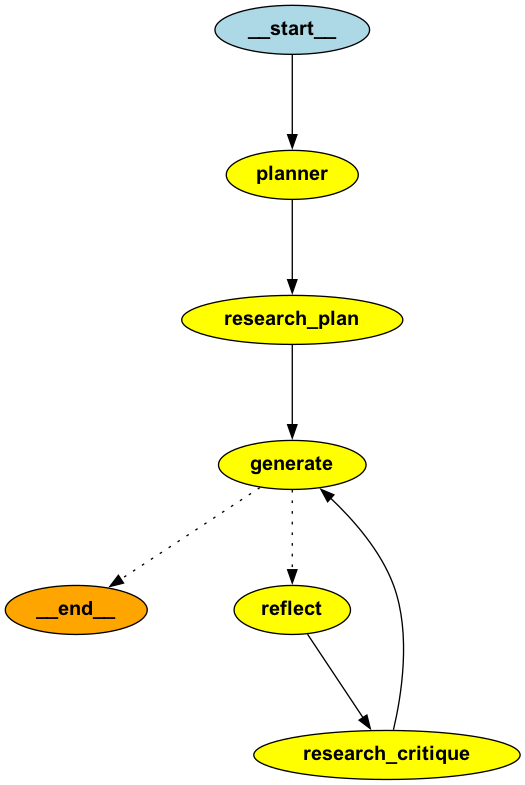

In [28]:
from IPython.display import Image

Image(graph.get_graph().draw_png())

In [29]:
thread = {"configurable": {"thread_id": "1"}}
for s in graph.stream({
    'task': "what is the difference between langchain and langsmith",
    "max_revisions": 2,
    "revision_number": 1,
}, thread):
    print(s)

{'planner': {'plan': '### Outline for Essay: "The Difference Between LangChain and LangSmith"\n\n#### I. Introduction\n   A. Brief introduction to the importance of language models and tools in modern technology.\n   B. Introduction to LangChain and LangSmith as prominent tools in the field.\n   C. Thesis statement: While LangChain and LangSmith both serve to enhance language model capabilities, they differ significantly in their design, functionality, and use cases.\n\n#### II. Overview of LangChain\n   A. Definition and Purpose\n      1. Explanation of what LangChain is.\n      2. Primary objectives and goals of LangChain.\n   B. Key Features\n      1. Core functionalities and features.\n      2. Unique selling points.\n   C. Use Cases\n      1. Typical scenarios where LangChain is applied.\n      2. Examples of industries or projects utilizing LangChain.\n\n#### III. Overview of LangSmith\n   A. Definition and Purpose\n      1. Explanation of what LangSmith is.\n      2. Primary obj